In [46]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
from sklearn import metrics
from random import randint
from matplotlib import style
import itertools

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


from IPython.display import display

import acquire
import env

# Exercise

## Clustering - DBSCAN

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

### Acquire

In [47]:
url = env.get_db_url('grocery_db')
query = 'SELECT * FROM grocery_customers'
df = pd.read_sql(query, url)
df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


### Prepare

In [48]:
# Make all columns lowercase
for col in df.columns:
    df = df.rename(columns={col: col.lower()})

In [49]:
# Rename the delicassen columns
df = df.rename(columns={'delicassen': 'deli'})
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   channel           440 non-null    int64
 2   region            440 non-null    int64
 3   fresh             440 non-null    int64
 4   milk              440 non-null    int64
 5   grocery           440 non-null    int64
 6   frozen            440 non-null    int64
 7   detergents_paper  440 non-null    int64
 8   deli              440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [53]:
df.describe()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,219.500000,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,127.161315,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,0.000000,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,109.750000,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,219.500000,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,329.250000,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,439.000000,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Scaling

In [52]:
cols = ['fresh', 'milk', 'grocery', 'frozen', 
        'detergents_paper', 'deli']

In [54]:
scaler = MinMaxScaler()
for col in cols:
    scaler.fit(df[[col]])
    df[f'scaled_{col}'] = scaler.transform(df[[col]])

### DB Scan

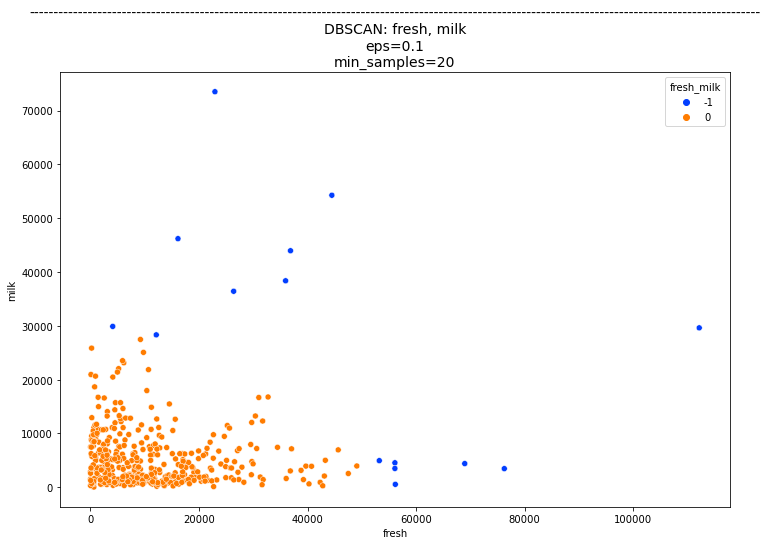

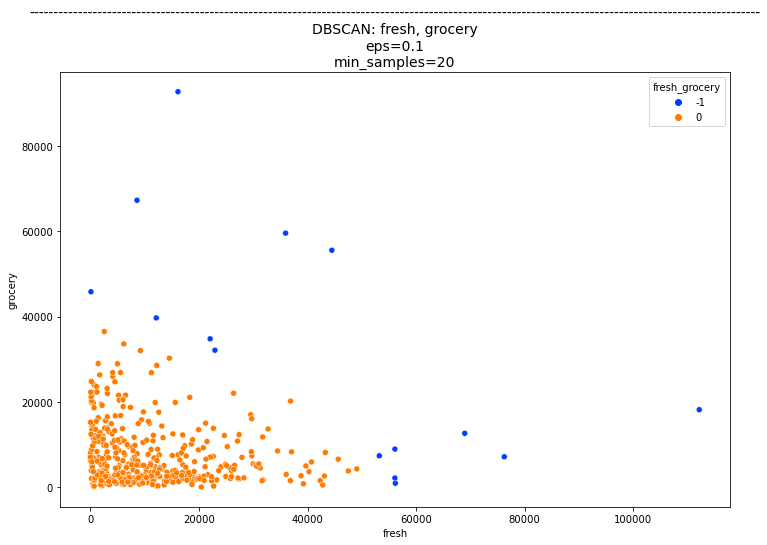

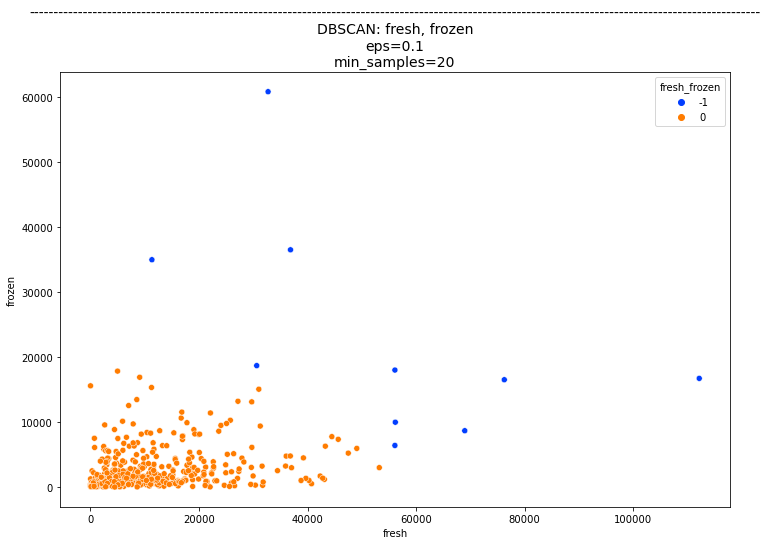

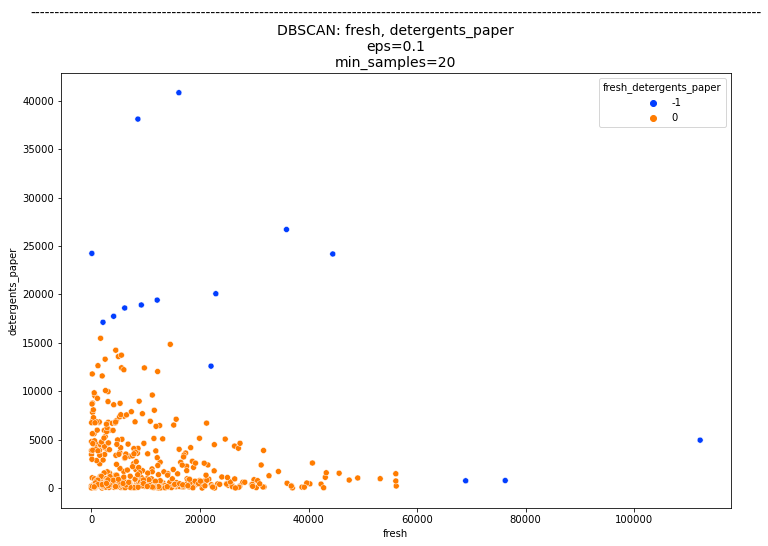

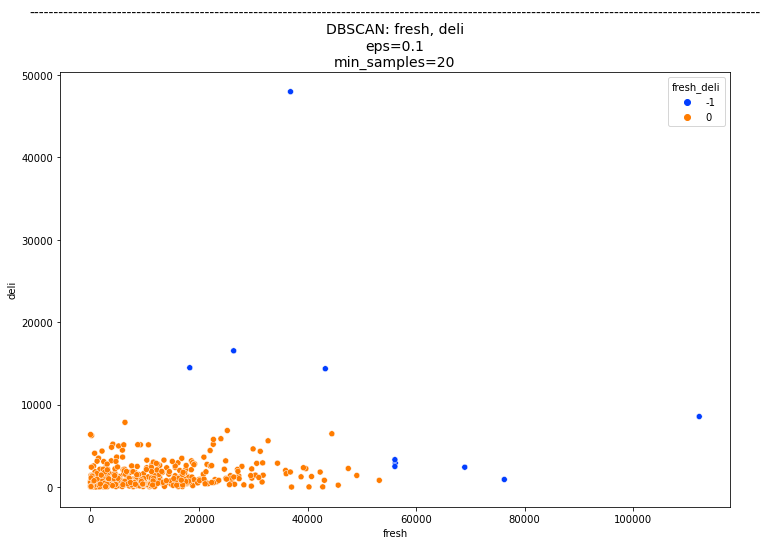

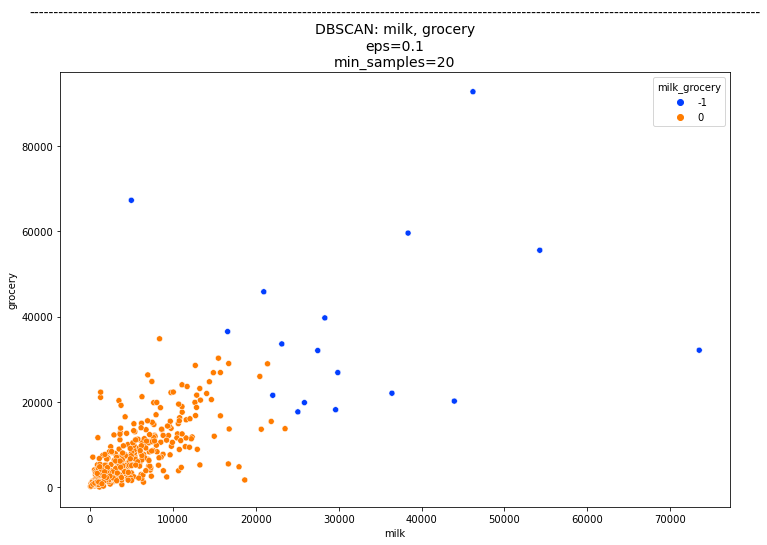

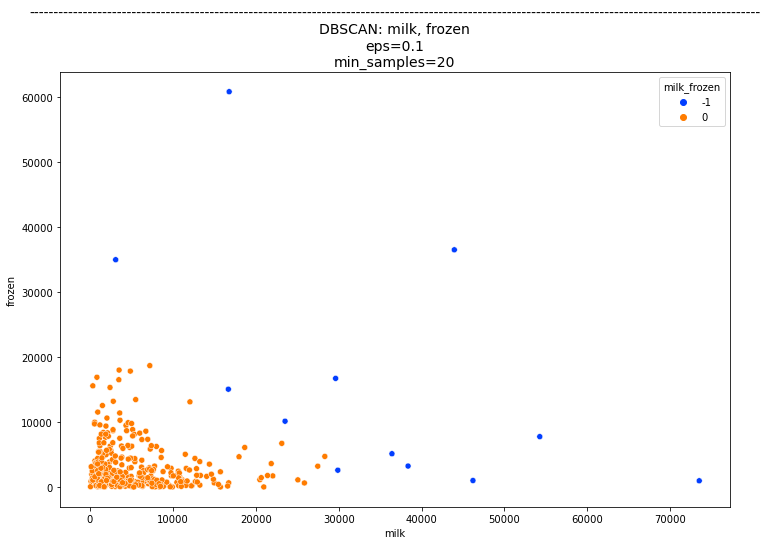

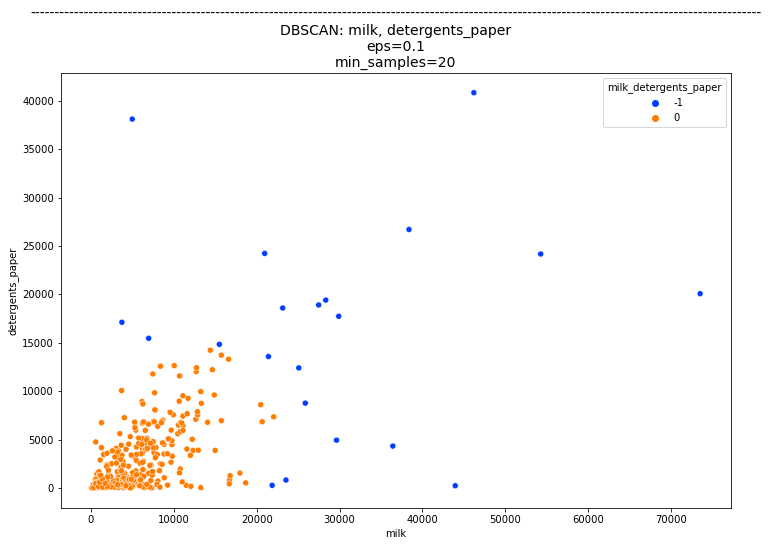

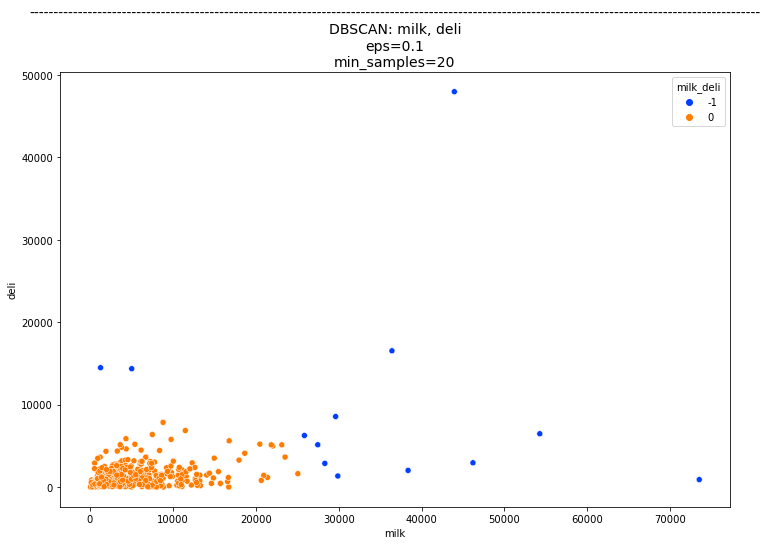

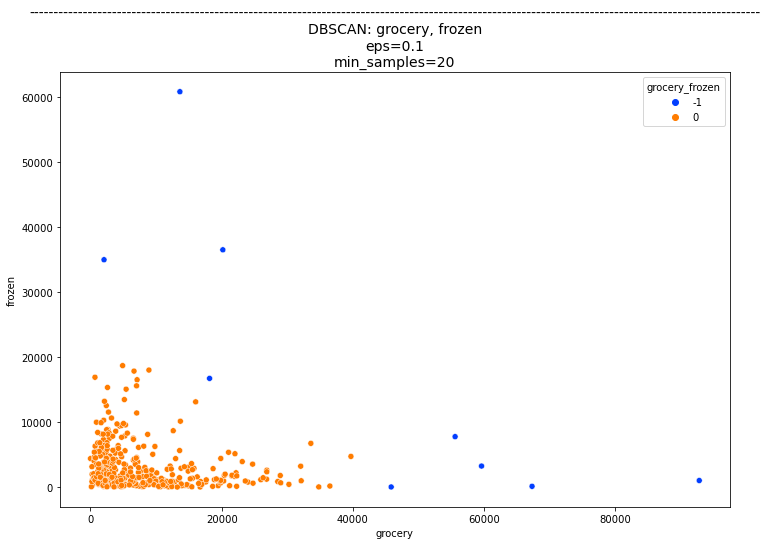

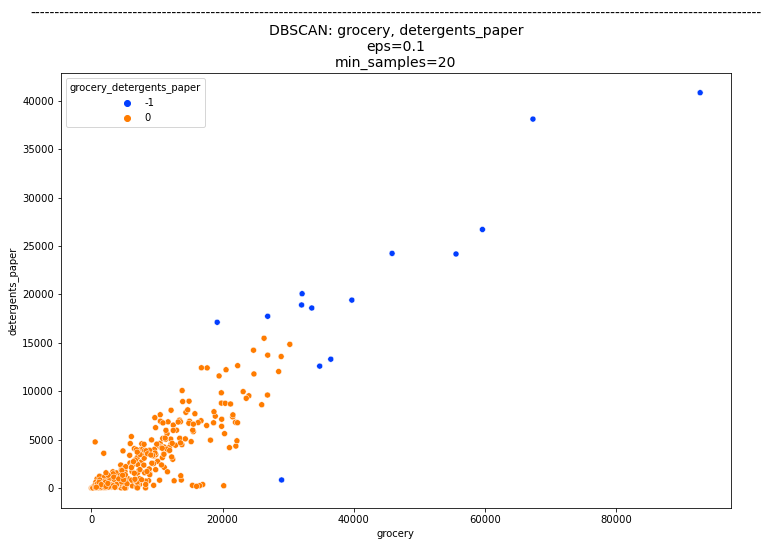

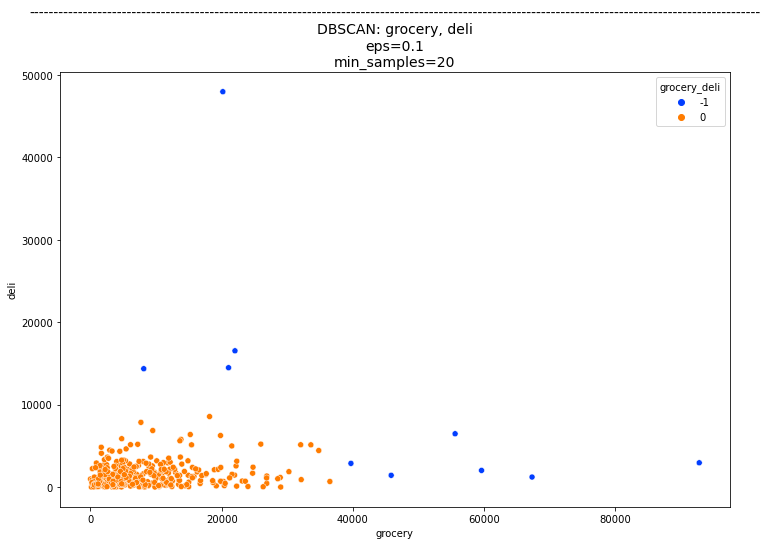

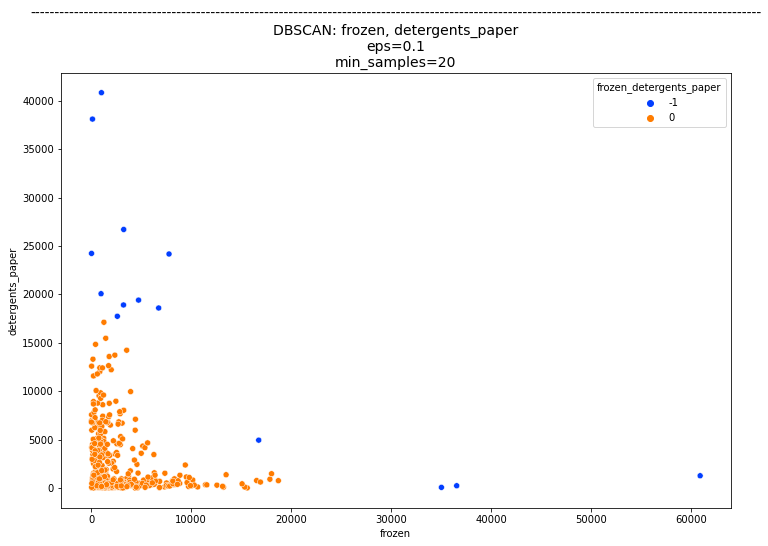

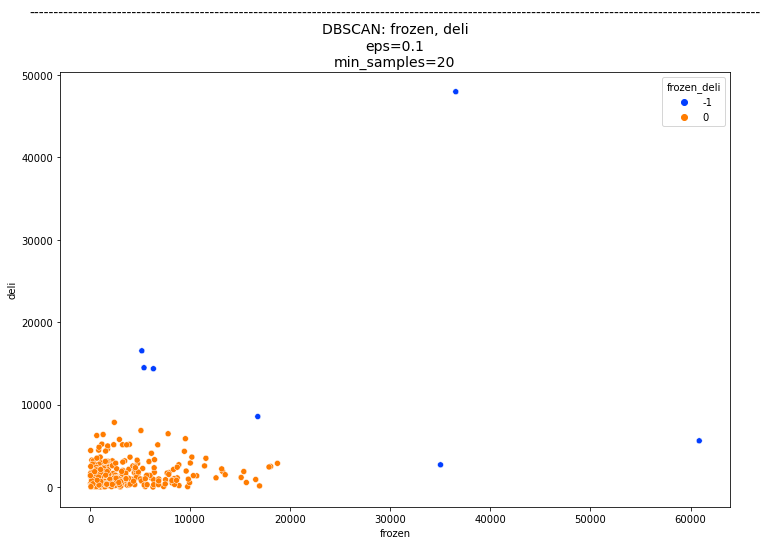

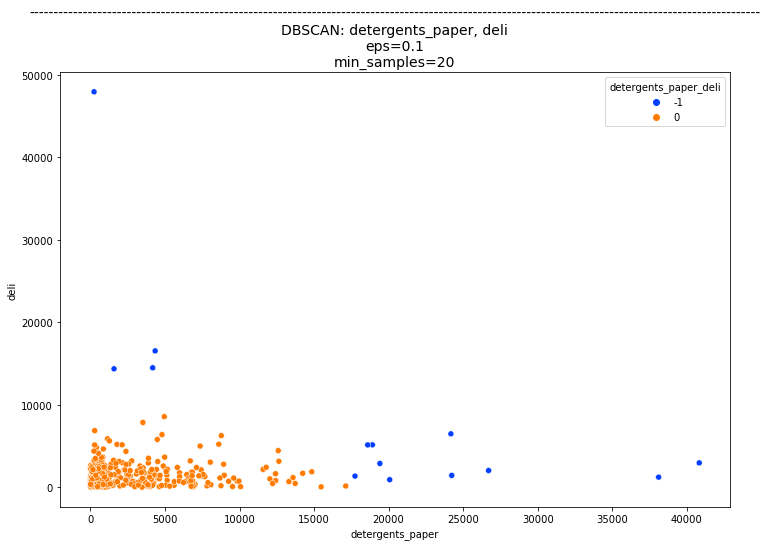

In [56]:
feature_set = ['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'deli']
feature_combos = itertools.combinations_with_replacement(feature_set, 2)

# for every combination of two features
for combo in feature_combos:
    if combo[0] != combo[1]:

        # establish a feature set
        features = combo

        # create the dbscan object
        dbsc = DBSCAN(eps=.1, min_samples=20)

        # fit the dbscan object 
        dbsc.fit(df[[f'scaled_{features[0]}', f'scaled_{features[1]}']])

        # add the dbscan labels as a new column to the df
        df[f'{features[0]}_{features[1]}'] = dbsc.labels_

        # plot the results
        plt.figure(figsize=(12,8))
        sns.scatterplot(df[features[0]], df[features[1]], 
                        hue=df[f'{features[0]}_{features[1]}'], 
                        palette='bright')
        plt.title(f'{"-"*150}\nDBSCAN: {features[0]}, {features[1]}\neps={eps}\nmin_samples={min_samples}',
                  fontdict={'fontsize':14})
        plt.show()